In [1]:
import os

# path of raw slide images
IMG_DIR = '/NAS01/Dataset/NLST/PathologySlide/raw'
# path of related tables
TBS_DIR = '/NAS01/Dataset/NLST/Pathology'

## Original Pathology Images

Firstly, we inspect the original pathology images from `IMG_DIR`
- Patients count 449
- Slides count 1225

In [2]:
pids = dict()
for d in os.listdir(IMG_DIR):
    dir_pid = os.path.join(IMG_DIR, d)
    if os.path.isdir(dir_pid):
        imgs = []
        for img_name in os.listdir(dir_pid):
            img_path = os.path.join(dir_pid, img_name)
            if not os.path.isfile(img_path):
                continue
            imgs.append(img_name)

        pids[d] = imgs

print("#Patient: %d" % len([_ for _ in pids.keys()]))
print("#Slide: %d" % sum([len(_) for _ in pids.values()]))

#Patient: 449
#Slide: 1225


check if there are SVS files having same name

In [3]:
img_names = []
for v in pids.values():
    img_names += v

print("#Unique Slide Name: %d" % len(set(img_names)))

#Unique Slide Name: 1225


## Table of Tissue Block

We check whether the informations read from `IMG_DIR` is consistent with table of pathology tissue blocks.

The table contains information as listed below.
- Tumor_id
- tissue_block_id
- pid
- pathology images filenames

In [4]:
import pandas as pd

path = os.path.join(TBS_DIR, "nlst_path_tissue_block_20180727.csv")
tissue_blk = pd.read_csv(path)

tissue_blk.head()

,tumor_id,tissue_block_id,block_annotated,block_color1,block_color2,block_color3,block_color4,block_color5,block_worst_class,block_worst_grade,pid,image_filesize1,image_filesize2,image_filename1,image_filename2
0,AA00116,AA00116 0001,1,BLACK,BLUE,PURPLE,RED,NaN,1.0,4.0,100012,836145827,NaN,11445.svs,NaN
1,AA00116,AA00116 0002,1,BLACK,BLUE,RED,YELLOW,NaN,1.0,4.0,100012,579406059,NaN,11446.svs,NaN
2,AA00116,AA00116 0003,1,GREEN,PURPLE,NaN,NaN,NaN,6.0,4.0,100012,759314583,NaN,11447.svs,NaN
3,AA00343,AA00343 0001,1,BLUE,BROWN,PURPLE,NaN,NaN,2.0,4.0,100147,230878457,NaN,NLSI0000526.svs,NaN
4,AA00681,AA00681 0001,1,BLACK,NaN,NaN,NaN,NaN,1.0,4.0,100158,468213351,NaN,9485.svs,NaN


In [5]:
tissue_blk_by_pid = tissue_blk.groupby(by='pid').groups
print("Read %d patients" % len(tissue_blk_by_pid))

for pid in pids:
    pid = int(pid)
    if pid not in tissue_blk_by_pid:
        print("Not found patient %s in Tissue_Block tables" % pid)
    
    tissues = tissue_blk.loc[tissue_blk_by_pid[pid], ['image_filename1', 'image_filename2']]
    tissues_imgs = list(tissues['image_filename1']) + list(tissues['image_filename2'])
    tissues_imgs = [_ for _ in tissues_imgs if not pd.isnull(_)]
    
    assert set(tissues_imgs) == set(pids[str(pid)])

Read 449 patients


Generate the table mapping pathology image id to patient id, which is saved in `TBS_DIR/nlst_path_path2pat.csv`

In [6]:
list_img_id = []
list_pid = []
for p in pids:
    img_id = [os.path.splitext(x)[0] for x in pids[p]]
    list_img_id += img_id
    list_pid += [p] * len(img_id)

map_path2pat = pd.DataFrame({'pathology_id': list_img_id, 'patient_id': list_pid}, columns=['pathology_id', 'patient_id'])

path = os.path.join(TBS_DIR, "nlst_path_path2pat.csv")
map_path2pat.to_csv(path, index=False)

## Table of Patients

We need to know the table of patients from NLST, and collect the informations (death status, including the time of death) that would be used in survival analysis.

For death analysis, we can use
- `candx_days`: Days from randomization to first diagnosis of lung cancer
- `fup_days` for non-death: Days from randomization to date last known alive
- `death_days` for death
- `deathstat`: Death status

In [7]:
path = os.path.join(TBS_DIR, "nlst_path_prsn_20180727.csv")
prsn = pd.read_csv(path)

prsn.head()

,cen,dataset_version,elig,ineligible,pid,rndgroup,study,age,educat,ethnic,...,clinical_m_7thed,path_t_7thed,path_n_7thed,path_m_7thed,clinical_t,path_t,clinical_n,path_n,clinical_m,path_m
0,AV,2011.02.03/04.07.20,2,NaN,100012,1,1,61,7,2,...,0.0,110.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0
1,AR,2011.02.03/04.07.20,2,NaN,100147,1,1,68,1,2,...,0.0,120.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0
2,AO,2011.02.03/04.07.20,2,NaN,100158,1,1,65,5,2,...,0.0,110.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0
3,BD,2011.02.03/04.07.20,2,NaN,100242,1,1,60,5,2,...,0.0,110.0,999.0,0.0,100.0,100.0,0.0,999.0,0.0,0.0
4,BC,2011.02.03/04.07.20,2,NaN,100280,1,1,60,6,2,...,0.0,110.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0


In [8]:
df_prsn = prsn.loc[:, ['pid', 'candx_days', 'fup_days', 'death_days', 'deathstat']]

list_pid = []
list_event = []
list_time = []
for i in df_prsn.index:
    list_pid.append(str(df_prsn.loc[i, 'pid']))
    if df_prsn.loc[i, 'deathstat'] == 1 or df_prsn.loc[i, 'deathstat'] == 2:
        assert df_prsn.loc[i, 'death_days'] == df_prsn.loc[i, 'fup_days']
        list_event.append(1)
        list_time.append(df_prsn.loc[i, 'death_days'] - df_prsn.loc[i, 'candx_days'])
    else:
        list_event.append(0)
        list_time.append(df_prsn.loc[i, 'fup_days'] - df_prsn.loc[i, 'candx_days'])

Save dataframe of pid, event, time to path of `TBS_DIR/nlst_path_patients.csv`

In [9]:
patients = pd.DataFrame({'patient_id': list_pid, 'e': list_event, 't': list_time}, columns=['patient_id', 'e', 't'])
path = os.path.join(TBS_DIR, "nlst_path_patients.csv")
patients.to_csv(path, index=False)

## Patients Overall Survival state

In [4]:
import pandas as pd
import os

path = os.path.join('/NAS01/Dataset/NLST/Pathology', "nlst_path_patients.csv")
patients = pd.read_csv(path)

print("# Rows", len(patients))
print("# Patients", len(patients['patient_id'].unique()))
print("# Event", patients['e'].sum())
print("Event ratio", patients['e'].sum() / len(patients))

# Rows 449
# Patients 449
# Event 161
Event ratio 0.3585746102449889


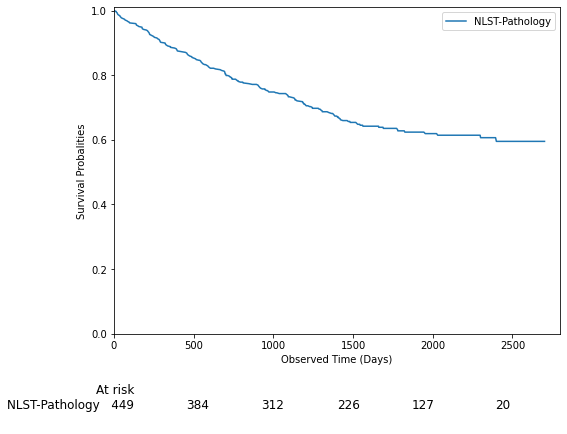

In [5]:
import lifelines as lf
import matplotlib.pyplot as plt
from lifelines.plotting import add_at_risk_counts

fig, ax = plt.subplots(figsize=(8, 6))

kmfh = lf.KaplanMeierFitter()
kmfh.fit(patients['t'], event_observed=patients['e'], label='NLST-Pathology')
kmfh.survival_function_.plot(ax=ax)

ax = add_at_risk_counts(kmfh, ax=ax, fig=fig, rows_to_show=[
                        'At risk'], fontsize=12)
ax.set_ylim(0, 1.01)
ax.set_xlim(0, 2800)
ax.set_xlabel("Observed Time (Days)")
ax.set_ylabel("Survival Probalities")

plt.show()